# Web Scraping Demo - Weather Data for London 

This is a simple web scraping demo, where I use Beautiful Soup to scrape the weather data for London from [the World Weather website](https://world-weather.info/forecast/united_kingdom/london/january-2015/), starting in January 2015 and ending in December 2021. Don't worry, I got permission!

First, let's import the libraries.

In [1]:
import requests
import os
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d #for smoothing
import warnings
warnings.filterwarnings("ignore")

Now for the fun part! Let's scrape the data from the website.

In [2]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', \
          'August', 'September', 'October', 'November', 'December']
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]

base_url = "https://world-weather.info/forecast/united_kingdom/london"

big_dataset = []

for month in months:
    for year in years:

        URL = os.path.join(base_url, month + '-' + str(year))
        page = requests.get(URL)

        soup = BeautifulSoup(page.content, "html.parser")
        all_elements = soup.find_all('li')
        
        highs = []
        lows = []
        
        #add the high temperatures
        for element in all_elements[15:55]:
            high = element.find("span")
            if high: #is not None
                highs.append(str(high.text))
        
        #add the low temperatures
        for element in all_elements[15:55]:
            low = element.find("p")
            if low: #is not None
                lows.append(str(low.text))
                
        for i in range(len(highs)):
            big_dataset.append([year, month, i+1, lows[i], highs[i]])

Now that we have the dataset in a big list of lists, let's turn this into a Pandas DataFrame. We then have to clean the data, which means getting rid of the ° sign, turning the temperatures from strings to integers, converting from Fahrenheit to Celsius, etc. I am also adding a 'date' column, so that each value has a (semi) unique identifier. 

In [3]:
#create dataframe
big_df = pd.DataFrame(big_dataset)

#rename columns
big_df.rename(columns = {0: "Year", 1: "Month", 2: "Day", 3: "Min Temp", 4: "Max Temp"}, inplace=True)

#clean temperatures. 

    #get rid of degree sign
big_df['Min Temp'] = big_df['Min Temp'].str.replace('°', '')
big_df['Max Temp'] = big_df['Max Temp'].str.replace('°', '')

    #convert to int:
big_df['Min Temp'] = big_df['Min Temp'].astype(int)
big_df['Max Temp'] = big_df['Max Temp'].astype(int)
    
    #convert to celsius
def f_to_c(value):
    return (value - 32)*5/9
   
    #change to 2 decimal points
big_df['Min Temp'] = round(f_to_c(big_df['Min Temp']), 2)
big_df['Max Temp'] = round(f_to_c(big_df['Max Temp']), 2)

#add mean temperature 
big_df['Mean Temp'] = round((big_df['Min Temp'] + big_df['Max Temp'])/2, 2)

#add date
big_df['Date'] = big_df.Day.astype(str) + " " + big_df.Month

In [4]:
big_df

,Year,Month,Day,Min Temp,Max Temp,Mean Temp,Date
0,2015,January,1,6.11,10.00,8.06,1 January
1,2015,January,2,12.78,8.89,10.84,2 January
2,2015,January,3,5.00,6.11,5.56,3 January
3,2015,January,4,3.89,3.89,3.89,4 January
4,2015,January,5,6.11,8.89,7.50,5 January
...,...,...,...,...,...,...,...
2540,2021,December,27,7.22,8.89,8.06,27 December
2541,2021,December,28,10.00,10.00,10.00,28 December
2542,2021,December,29,7.78,13.89,10.84,29 December
2543,2021,December,30,13.89,15.00,14.44,30 December


Now that we have the big dataset with all of the information we need, we can trim this down into smaller datasets tailored for some specific questions.

## Mean Temperature by Year

Let's see how the mean temperature changed yearly. This means that we will have to group by year.

In [5]:
by_year = big_df.groupby(by=["Year"], as_index=False).mean()
by_year

,Year,Day,Min Temp,Max Temp,Mean Temp
0,2015,15.681319,11.336978,14.293352,12.815027
1,2016,15.678571,11.175220,14.242967,12.709286
2,2017,15.678571,11.526099,14.414038,12.970110
3,2018,15.636364,11.613140,14.778292,13.195730
4,2019,15.639118,11.414187,14.640413,13.027218
5,2020,15.717808,11.710658,15.089808,13.400082
6,2021,15.604972,10.661077,13.638702,12.149834


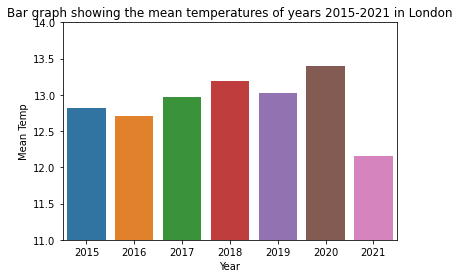

In [6]:
sns.barplot(data=by_year, x='Year', y='Mean Temp')
plt.ylim(11, 14)
plt.title("Bar graph showing the mean temperatures of years 2015-2021 in London")
plt.show()

As we can see, the mean temperatures hover around the 13°C mark. However, 2021 has been particularly colder, with an average temperature of 12.1°C. This is interesting because most people are expecting the UK to become warmer as a result of 'global warming' - we must reject this term and instead use _climate change_, which is more accurate. Still, this may of course be an outlier.

## Group by Month and Year

Let us now look at each year within each month.

In [7]:
by_year_month = big_df.groupby(by=["Year", 'Month'], as_index=False).mean()
print(by_year_month.to_string())

    Year      Month   Day   Min Temp   Max Temp  Mean Temp
0   2015      April  15.5   8.926000  13.315000  11.119667
1   2015     August  16.0  17.131935  21.021290  19.076452
2   2015   December  16.0  12.025484  12.939032  12.482581
3   2015   February  14.5   4.583214   6.825357   5.703929
4   2015    January  16.0   5.699032   6.918065   6.309355
5   2015       July  16.0  17.383548  21.200645  19.291613
6   2015       June  15.0  14.808276  19.061034  16.934138
7   2015      March  16.0   7.221935   9.875161   8.548387
8   2015        May  16.0  11.702258  15.716129  13.708710
9   2015   November  15.5  11.037333  12.389333  11.713333
10  2015    October  16.0  11.845484  14.820968  13.333548
11  2015  September  15.5  13.223000  17.018000  15.120333
12  2016      April  15.5   8.111333  11.574333   9.843667
13  2016     August  15.5  17.963000  22.314667  20.138333
14  2016   December  16.0   7.347742   9.139677   8.243871
15  2016   February  14.5   5.754286   8.173571   6.9632

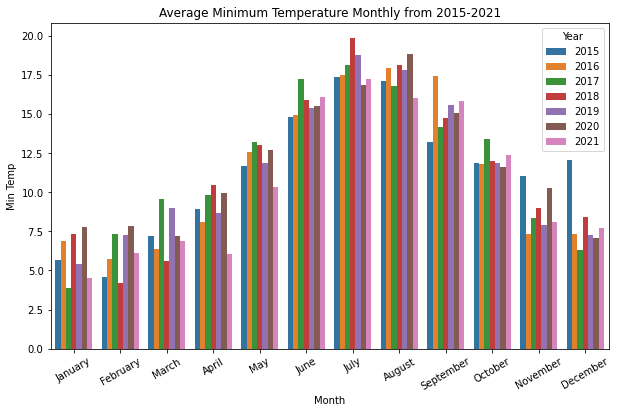

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(data=by_year_month, x='Month', y='Min Temp', hue="Year", order=months)
plt.xticks(rotation=30)
plt.title("Average Minimum Temperature Monthly from 2015-2021")
plt.show()

This plot may be a bit ugly, but it highlights how the mean minimum temperature of each month changed from year to year. Some example insights are:
- March 2021 was warmer than April 2021
- That the mean minimum (nighttime) temperature of December 2015 was around 12°C, which is incredibly warm, more so than even May or October of the same year, which is a clear anomaly (I thought that this was a mistake, but this is indeed true, as described in [this article](https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/weather/learn-about/uk-past-events/interesting/2015/exceptional-warmth-december-2015---met-office.pdf) by the Met Office).

More insights can be found by comparing the minimum and maximum temperatures. 

## Temperature Across One Year

Let us now individually analyse the temperatures across one year. Without loss of generality, let's use 2018.

In [9]:
df_2018 = big_df[big_df.Year == 2018]

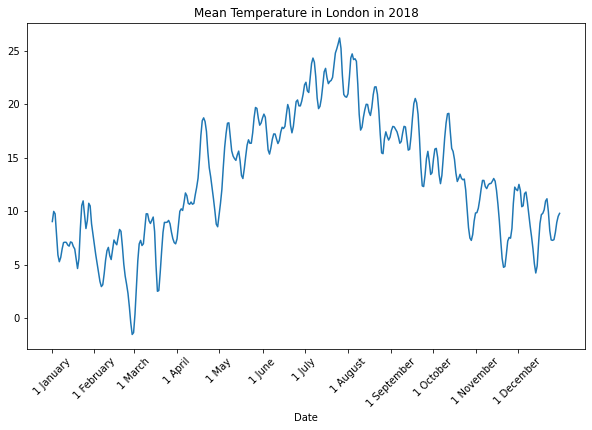

In [10]:
x_labels = ['1' + ' ' + month for month in months]
x=df_2018.Date
y=df_2018['Mean Temp']
ysmoothed = gaussian_filter1d(y, sigma=1) #smooth the line
plt.figure(figsize=(10,6))
sns.lineplot(x, ysmoothed)
plt.xticks(x_labels, rotation=45)
plt.title("Mean Temperature in London in 2018")
plt.show()

We can see a predictable pattern - a normal-like shaped curve, representing lower mean temperatures at the early and late points in the year, and higher mean temperatures in the middle of the year. There was a dip in late February/early March (which was due to the Beast from the East - you may well remember), and the peak seemed to be in late July (as well, a scorching summer, during which I wasn't even in the country. Grr.).

## Temperature Across All Years

Let us now see an ugly graph for the mean temperature for all years. I tried so hard to make this graph look pretty, but unfortunately when I smoothed it too much, it looked blocky. 

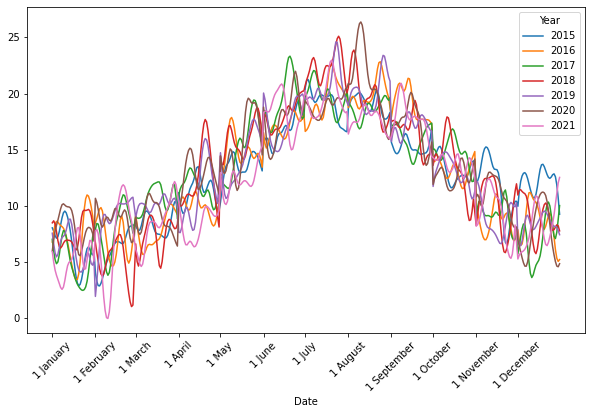

In [11]:
x_labels = ['1' + ' ' + month for month in months]

plt.figure(figsize=(10,6))

x = big_df.Date
y = big_df['Mean Temp']
y_smoothed = gaussian_filter1d(y, sigma=2)
sns.lineplot(x, y_smoothed, hue=big_df.Year, palette='tab10')
plt.xticks(x_labels, rotation=45)
plt.show()

Luckily, despite the ugliness, we can still see several outliers: 
- cold period in early February 2021
- cold period in late February 2018
- hot period in early August 2020
- abnormally warm December 2015.

Thank you very much for making it this far. I hope you enjoyed the insights from this weather data. Feel free to give me any feedback on my methodologies, be they the web scraping itself or the graph-making. 